In [ ]:
import os
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


dbURL = os.getenv("DATABASE_URL", "sqlite:///development/data_sources/hass.db")
engine = sqlalchemy.create_engine(dbURL)
hassConn = engine.connect()


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [213]:
entity_id = "sensor.total_solar_production_roof"

# get statistics id
statement = sqlalchemy.text("""
    SELECT id FROM "statistics_meta"
    WHERE statistic_id = :entity_id
""")
result = hassConn.execute(statement, {"entity_id": entity_id})
result = result.fetchone()

id = result[0]
print(f"Statistic ID: {id}")


## Get the statistics from the database
query = f"""
SELECT *
FROM "statistics"
WHERE "metadata_id" = {id}
"""

stats = pd.read_sql_query(query, engine)

# Convert timestamps to datetime and process solar data
stats['start_ts'] = pd.to_datetime(stats['start_ts'], unit='s')
stats['created_ts'] = pd.to_datetime(stats['created_ts'], unit='s')

# Calculate hourly solar production (kWh)
# The 'sum' column appears to be cumulative, so we need to calculate differences
stats_sorted = stats.sort_values('start_ts').copy()
stats_sorted['solar_kwh'] = stats_sorted['sum'].diff()

# Remove negative values (can happen due to data quality issues)
stats_sorted = stats_sorted[stats_sorted['solar_kwh'] >= 0]

# Set the datetime index
stats_sorted = stats_sorted.set_index('start_ts')
stats_sorted = stats_sorted[['solar_kwh']]

print(f"Solar data shape: {stats_sorted.shape}")
print(f"Date range: {stats_sorted.index.min()} to {stats_sorted.index.max()}")
print("\nFirst few rows of processed solar data:")

print(stats_sorted.tail())

Statistic ID: 739
Solar data shape: (29857, 1)
Date range: 2022-06-10 11:00:00 to 2025-11-09 09:00:00

First few rows of processed solar data:
                     solar_kwh
start_ts                      
2025-11-09 05:00:00       0.00
2025-11-09 06:00:00       0.00
2025-11-09 07:00:00       0.09
2025-11-09 08:00:00       0.22
2025-11-09 09:00:00       0.18
Solar data shape: (29857, 1)
Date range: 2022-06-10 11:00:00 to 2025-11-09 09:00:00

First few rows of processed solar data:
                     solar_kwh
start_ts                      
2025-11-09 05:00:00       0.00
2025-11-09 06:00:00       0.00
2025-11-09 07:00:00       0.09
2025-11-09 08:00:00       0.22
2025-11-09 09:00:00       0.18


In [214]:
# get first and last date from stats_sorted
start_date = stats_sorted.index.min()
end_date = stats_sorted.index.max()

In [215]:
# Load and process weather data
#knmi_df = pd.read_csv('../data_sources/hourly_knmi_weather', usecols=['datetime', 'temperature', 'irradiance'])
#knmi_df['datetime'] = pd.to_datetime(knmi_df['datetime'])
#knmi_df = knmi_df.set_index('datetime')

#print(f"Weather data shape: {knmi_df.shape}")
#print(f"Weather date range: {knmi_df.index.min()} to {knmi_df.index.max()}")
#print("\nWeather data columns:")
#print(knmi_df.columns.tolist())
#print("\nFirst few rows of weather data:")
#print(knmi_df.head())


import knmi
def fetch_knmi_weather(station, start, end):
    print("Fetching KNMI data from", start, "to", end, "...")
    df_hourly = knmi.get_hour_data_dataframe(
        stations=[station],
        start=start,
        end=end,
        variables=["T", "RH", "Q"]
        #variables=["T", "RH", "Q", "FH"]
    )
    df_hourly["T"] = df_hourly["T"] / 10.0 # convert to °C
    #df_hourly["RH"] = df_hourly["RH"] / 10.0 # conver to mm
    #df_hourly["FH"] = df_hourly["FH"] / 10.0 # convert to m/s
    df_hourly = df_hourly.rename(columns={
        "T": "temperature",
        "RH": "precipitation",
        "Q": "irradiance", # in J/cm2
        #"FH": "wind_speed"
    })
    print("Fetched KNMI data with shape:", df_hourly.shape)

    # rename index YYYYMMDD_HH to datetime
    df_hourly = df_hourly.reset_index().rename(columns={"YYYYMMDD_HH": "datetime"})

    df_hourly['datetime'] = pd.to_datetime(df_hourly['datetime'])
    df_hourly = df_hourly.set_index('datetime') 

    return df_hourly[['temperature','irradiance', 'precipitation']]

station = 275  # Deelen Airport

knmi_df = fetch_knmi_weather(station, start_date, end_date)
knmi_df = knmi_df[(knmi_df.index >= start_date) & (knmi_df.index <= end_date)]

print(f"Weather data shape: {knmi_df.shape}")
print(f"Weather date range: {knmi_df.index.min()} to {knmi_df.index.max()}")
print("\nWeather data columns:")
print(knmi_df.columns.tolist())
print("\nFirst few rows of weather data:")
print(knmi_df.tail())


Fetching KNMI data from 2022-06-10 11:00:00 to 2025-11-09 09:00:00 ...
Fetched KNMI data with shape: (29976, 4)
Weather data shape: (29951, 3)
Weather date range: 2022-06-10 11:00:00 to 2025-11-09 09:00:00

Weather data columns:
['temperature', 'irradiance', 'precipitation']

First few rows of weather data:
                     temperature  irradiance  precipitation
datetime                                                   
2025-11-09 05:00:00         10.5           0              0
2025-11-09 06:00:00         10.6           0              0
2025-11-09 07:00:00         10.7           6              0
2025-11-09 08:00:00         11.7          18              0
2025-11-09 09:00:00         12.6          34              0
Fetched KNMI data with shape: (29976, 4)
Weather data shape: (29951, 3)
Weather date range: 2022-06-10 11:00:00 to 2025-11-09 09:00:00

Weather data columns:
['temperature', 'irradiance', 'precipitation']

First few rows of weather data:
                     temperature 

In [216]:
entity_id = "sensor.gw2000c_outdoor_temperature"

# get statistics id
statement = sqlalchemy.text("""
    SELECT id FROM "statistics_meta"
    WHERE statistic_id = :entity_id
""")
result = hassConn.execute(statement, {"entity_id": entity_id})
result = result.fetchone()

id = result[0]
print(f"Statistic ID: {id}")


## Get the statistics from the database
query = f"""
SELECT *
FROM "statistics"
WHERE "metadata_id" = {id}
"""

hass_temp = pd.read_sql_query(query, engine)

print(f"Temperature data shape: {hass_temp.shape}")
hass_temp['start_ts'] = pd.to_datetime(hass_temp['start_ts'], unit='s')
hass_temp = hass_temp.set_index('start_ts')
hass_temp = hass_temp.sort_index()
hass_temp = hass_temp[['mean']].rename(columns={'mean': 'temperature'})


print(hass_temp.tail())

Statistic ID: 1002
Temperature data shape: (12515, 14)
                     temperature
start_ts                        
2025-11-09 05:00:00    10.902661
2025-11-09 06:00:00    10.766218
2025-11-09 07:00:00    10.769510
2025-11-09 08:00:00    11.284041
2025-11-09 09:00:00    11.649917


In [217]:
entity_id = "sensor.gw2000c_hourly_rain_rate_piezo"

# get statistics id
statement = sqlalchemy.text("""
    SELECT id FROM "statistics_meta"
    WHERE statistic_id = :entity_id
""")
result = hassConn.execute(statement, {"entity_id": entity_id})
result = result.fetchone()

id = result[0]
print(f"Statistic ID: {id}")


## Get the statistics from the database
query = f"""
SELECT *
FROM "statistics"
WHERE "metadata_id" = {id}
"""

hass_precipitation = pd.read_sql_query(query, engine)

print(f"Temperature data shape: {hass_precipitation.shape}")
hass_precipitation['start_ts'] = pd.to_datetime(hass_precipitation['start_ts'], unit='s')
hass_precipitation = hass_precipitation.set_index('start_ts')
hass_precipitation = hass_precipitation.sort_index()
hass_precipitation = hass_precipitation[['mean']].rename(columns={'mean': 'precipitation'})


print(hass_precipitation.tail())

Statistic ID: 1009
Temperature data shape: (12515, 14)
                     precipitation
start_ts                          
2025-11-09 05:00:00       0.000000
2025-11-09 06:00:00       0.000000
2025-11-09 07:00:00       0.000000
2025-11-09 08:00:00       0.000000
2025-11-09 09:00:00       0.046556


In [218]:
entity_id = "sensor.gw2000c_solar_radiation" # W/m2

# get statistics id
statement = sqlalchemy.text("""
    SELECT id FROM "statistics_meta"
    WHERE statistic_id = :entity_id
""")
result = hassConn.execute(statement, {"entity_id": entity_id})
result = result.fetchone()

id = result[0]
print(f"Statistic ID: {id}")


## Get the statistics from the database
query = f"""
SELECT *
FROM "statistics"
WHERE "metadata_id" = {id}
"""

hass_solar_rad = pd.read_sql_query(query, engine)

print(f"Solar radiation data shape: {hass_solar_rad.shape}")
hass_solar_rad['start_ts'] = pd.to_datetime(hass_solar_rad['start_ts'], unit='s')
hass_solar_rad = hass_solar_rad.set_index('start_ts')
hass_solar_rad = hass_solar_rad.sort_index()
hass_solar_rad = hass_solar_rad[['mean']].rename(columns={'mean': 'solar_radiation'})

# convert W/m2 to J/cm²/h
hass_solar_rad['solar_radiation'] = hass_solar_rad['solar_radiation'] * 0.36

#rename solar_radiation to match knmi
hass_solar_rad = hass_solar_rad.rename(columns={'solar_radiation': 'irradiance'})

print(hass_solar_rad.tail())

Statistic ID: 997
Solar radiation data shape: (12515, 14)
                     irradiance
start_ts                       
2025-11-09 05:00:00    0.000000
2025-11-09 06:00:00    0.304917
2025-11-09 07:00:00    4.641364
2025-11-09 08:00:00    9.884184
2025-11-09 09:00:00    8.346685
Solar radiation data shape: (12515, 14)
                     irradiance
start_ts                       
2025-11-09 05:00:00    0.000000
2025-11-09 06:00:00    0.304917
2025-11-09 07:00:00    4.641364
2025-11-09 08:00:00    9.884184
2025-11-09 09:00:00    8.346685


In [219]:
# create union between hass_solar_rad and hass_temp
hass_weather = pd.concat([hass_temp, hass_solar_rad, hass_precipitation], axis=1)

hass_weather = hass_weather[(hass_weather.index >= start_date) & (hass_weather.index <= end_date)]

print(f"HASS weather data shape: {hass_weather.shape}")
print(hass_weather.tail())

HASS weather data shape: (12515, 3)
                     temperature  irradiance  precipitation
start_ts                                                   
2025-11-09 05:00:00    10.902661    0.000000       0.000000
2025-11-09 06:00:00    10.766218    0.304917       0.000000
2025-11-09 07:00:00    10.769510    4.641364       0.000000
2025-11-09 08:00:00    11.284041    9.884184       0.000000
2025-11-09 09:00:00    11.649917    8.346685       0.046556


In [220]:
import sys
sys.path.append('../../')
import solar_predictor


In [221]:
# truncate knmi and hass datasets to match an entire day
end = end_date.replace(hour=0, minute=0, second=0)
knmi_df = knmi_df[(knmi_df.index >= start_date) & (knmi_df.index <= end)]
hass_weather = hass_weather[(hass_weather.index >= start_date) & (hass_weather.index <= end)]

#train the models base on full days only, but don't use the last day for training
# so we can use it for comparing predictions later
knmi_train = knmi_df[knmi_df.index < end - pd.Timedelta(days=1)]
hass_train = hass_weather[hass_weather.index < end - pd.Timedelta(days=1)]


model_knmi = solar_predictor.SolarPredictor()
# Train using DataFrames
training_stats = model_knmi.train(
    weather_data=knmi_train,
    solar_data=stats_sorted,
    model_save_path="./knmi_model.pkl",
    test_size=0.3,
    remove_outliers=True,
    tune_hyperparameters=True
)

print(f"\nModel trained successfully!")
print(f"Test R² Score: {training_stats['test_r2']:.3f}")


# build model based on hass data
model_hass = solar_predictor.SolarPredictor()
# Train using DataFrames
training_stats = model_hass.train(
    weather_data=hass_train,
    solar_data=stats_sorted,
    model_save_path="./hass_model.pkl",
    test_size=0.3,
    remove_outliers=True,
    tune_hyperparameters=True
)

print(f"\nModel trained successfully!")
print(f"Test R² Score: {training_stats['test_r2']:.3f}")




Starting solar prediction model training...
Loading and processing data...
Merging weather and solar data...
Merged dataset: 29917 records
Date range: 2022-06-10 11:00:00+00:00 to 2025-11-07 23:00:00+00:00
Detecting outliers...
Outliers removed: 915 (3.1%)
Clean dataset: 29002 records
Outliers removed: 915 (3.1%)
Clean dataset: 29002 records
Training samples: 20301
Testing samples: 8701
Tuning hyperparameters...
Training samples: 20301
Testing samples: 8701
Tuning hyperparameters...
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
Training final model...

Model Training Complete!
Model saved to: ./knmi_model.pkl
Training MAE: 0.1546 kWh
Testing MAE: 0.1715 kWh
Training R²: 0.9186
Testing R²: 0.9011

Model trained successfully!
Test R² Score: 0.901
Starting solar prediction model training...
Loading and processing data...
Merging weather and solar data...
Merged dataset: 12481 records
Date range: 2024-06-04 19:00:00+00:00 to 2025-11-07 23:0

In [222]:
# now use the last full day for prediction on both models
predict_start = end - pd.Timedelta(days=1)
predict_end = end 

# get the relevant weather data for the prediction period
knmi_w = knmi_df[(knmi_df.index >= predict_start) & (knmi_df.index <= predict_end)]
hass_w = hass_weather[(hass_weather.index >= predict_start) & (hass_weather.index <= predict_end)]


pred_knmi = model_knmi.predict(knmi_w)
# merge data back into DataFrame with datetime index
pred_knmi = pd.DataFrame(pred_knmi, index=knmi_w.index)
pred_knmi = knmi_w.join(pred_knmi)
merged_knmi = stats_sorted.join(pred_knmi, how='inner')

pred_hass = model_hass.predict(hass_w)
pred_hass = pd.DataFrame(pred_hass, index=hass_w.index)
pred_hass = hass_w.join(pred_hass)
merged_hass = stats_sorted.join(pred_hass, how='inner')

print("KNMI Predictions:")
print(merged_knmi.tail())
print("HASS Predictions:")
print(merged_hass.tail())


KNMI Predictions:
                     solar_kwh  temperature  irradiance  precipitation  \
2025-11-08 20:00:00        0.0         10.9           0              0   
2025-11-08 21:00:00        0.0         10.8           0             -1   
2025-11-08 22:00:00        0.0         10.4           0             -1   
2025-11-08 23:00:00        0.0         10.4           0              0   
2025-11-09 00:00:00        0.0         10.5           0              0   

                            0  
2025-11-08 20:00:00  0.010082  
2025-11-08 21:00:00  0.010082  
2025-11-08 22:00:00  0.010082  
2025-11-08 23:00:00  0.010082  
2025-11-09 00:00:00  0.006744  
HASS Predictions:
                     solar_kwh  temperature  irradiance  precipitation  \
start_ts                                                                 
2025-11-08 20:00:00        0.0    11.571927         0.0            0.0   
2025-11-08 21:00:00        0.0    11.435134         0.0            0.0   
2025-11-08 22:00:00        0.0 

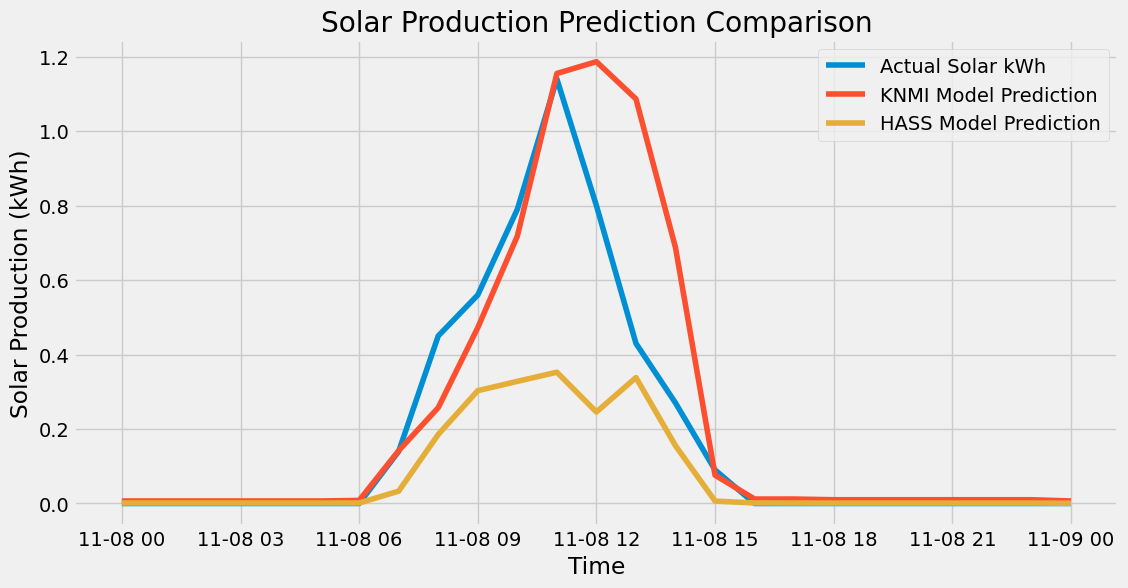

In [223]:
# plot the results, comparing actual solar_kwh with predictions from both models
plt.figure(figsize=(12, 6))
plt.plot(stats_sorted.loc[predict_start:predict_end].index, stats_sorted.loc[predict_start:predict_end]['solar_kwh'], label='Actual Solar kWh', color=color_pal[0])
plt.plot(merged_knmi.index, merged_knmi[0], label='KNMI Model Prediction', color=color_pal[1])
plt.plot(merged_hass.index, merged_hass[0], label='HASS Model Prediction', color=color_pal[2])
plt.xlabel('Time')
plt.ylabel('Solar Production (kWh)')
plt.title('Solar Production Prediction Comparison')
plt.legend()
plt.show()

In [224]:
# Analyze why HASS model predicts lower than KNMI model
print("=== COMPARATIVE ANALYSIS: HASS vs KNMI Models ===")
print()

# 1. Compare the prediction ranges
knmi_predictions = merged_knmi[0].values
hass_predictions = merged_hass[0].values

print("--- Prediction Statistics ---")
print(f"KNMI predictions - Mean: {knmi_predictions.mean():.4f}, Std: {knmi_predictions.std():.4f}")
print(f"HASS predictions - Mean: {hass_predictions.mean():.4f}, Std: {hass_predictions.std():.4f}")
print(f"Difference (KNMI - HASS): {(knmi_predictions.mean() - hass_predictions.mean()):.4f} kWh")
print(f"Ratio (KNMI / HASS): {knmi_predictions.mean() / hass_predictions.mean():.2f}x")

# 2. Compare input data ranges and quality
print(f"\n--- Input Data Comparison ---")
print(f"Temperature:")
print(f"  KNMI range: {knmi_w['temperature'].min():.1f} to {knmi_w['temperature'].max():.1f}°C")
print(f"  HASS range: {hass_w['temperature'].min():.1f} to {hass_w['temperature'].max():.1f}°C")
print(f"  Correlation: {knmi_w['temperature'].corr(hass_w['temperature']):.3f}")

print(f"\nIrradiance:")
print(f"  KNMI range: {knmi_w['irradiance'].min():.1f} to {knmi_w['irradiance'].max():.1f} J/cm²/h")
print(f"  HASS range: {hass_w['irradiance'].min():.1f} to {hass_w['irradiance'].max():.1f} J/cm²/h")
print(f"  Correlation: {knmi_w['irradiance'].corr(hass_w['irradiance']):.3f}")

print(f"\nPrecipitation:")
print(f"  KNMI range: {knmi_w['precipitation'].min():.1f} to {knmi_w['precipitation'].max():.1f} mm")
print(f"  HASS range: {hass_w['precipitation'].min():.1f} to {hass_w['precipitation'].max():.1f} mm")
print(f"  Correlation: {knmi_w['precipitation'].corr(hass_w['precipitation']):.3f}")

# 3. Compare training data characteristics
print(f"\n--- Training Data Characteristics ---")
print(f"KNMI training data:")
print(f"  Shape: {knmi_train.shape}")
print(f"  Irradiance mean: {knmi_train['irradiance'].mean():.1f} J/cm²/h")
print(f"  Irradiance max: {knmi_train['irradiance'].max():.1f} J/cm²/h")
print(f"  Temperature mean: {knmi_train['temperature'].mean():.1f}°C")

print(f"\nHASS training data:")
print(f"  Shape: {hass_train.shape}")
print(f"  Irradiance mean: {hass_train['irradiance'].mean():.1f} J/cm²/h")
print(f"  Irradiance max: {hass_train['irradiance'].max():.1f} J/cm²/h")
print(f"  Temperature mean: {hass_train['temperature'].mean():.1f}°C")

=== COMPARATIVE ANALYSIS: HASS vs KNMI Models ===

--- Prediction Statistics ---
KNMI predictions - Mean: 0.2368, Std: 0.3911
HASS predictions - Mean: 0.0787, Std: 0.1270
Difference (KNMI - HASS): 0.1582 kWh
Ratio (KNMI / HASS): 3.01x

--- Input Data Comparison ---
Temperature:
  KNMI range: 2.5 to 13.0°C
  HASS range: 4.7 to 12.9°C
  Correlation: 0.918

Irradiance:
  KNMI range: 0.0 to 54.0 J/cm²/h
  HASS range: 0.0 to 22.0 J/cm²/h
  Correlation: 0.944

Precipitation:
  KNMI range: -1.0 to 0.0 mm
  HASS range: 0.0 to 0.0 mm
  Correlation: nan

--- Training Data Characteristics ---
KNMI training data:
  Shape: (29917, 3)
  Irradiance mean: 46.5 J/cm²/h
  Irradiance max: 335.0 J/cm²/h
  Temperature mean: 11.9°C

HASS training data:
  Shape: (12481, 3)
  Irradiance mean: 39.2 J/cm²/h
  Irradiance max: 330.1 J/cm²/h
  Temperature mean: 13.3°C


In [225]:
# Compare model internals and feature importance
print("=== MODEL INTERNALS COMPARISON ===")
print()

# 1. Feature importance comparison
print("--- Feature Importance Analysis ---")
knmi_importance = model_knmi.get_feature_importance()
hass_importance = model_hass.get_feature_importance()

print("Feature Importance Comparison:")
print(f"{'Feature':<15} {'KNMI':<10} {'HASS':<10} {'Difference':<12}")
print("-" * 50)
for feature in knmi_importance.keys():
    knmi_val = knmi_importance[feature]
    hass_val = hass_importance[feature] 
    diff = knmi_val - hass_val
    print(f"{feature:<15} {knmi_val:<10.3f} {hass_val:<10.3f} {diff:+10.3f}")

# 2. Compare how models respond to same input ranges
print(f"\n--- Model Response Analysis ---")

# Test with identical input scenarios
test_scenarios = [
    {'hour': 12, 'temp': 20, 'irradiance': 200, 'precipitation': 0},  # Medium sun
    {'hour': 12, 'temp': 25, 'irradiance': 400, 'precipitation': 0},  # Good sun
    {'hour': 12, 'temp': 30, 'irradiance': 600, 'precipitation': 0},  # Excellent sun
    {'hour': 14, 'temp': 15, 'irradiance': 100, 'precipitation': 0},  # Poor conditions
]

print("Identical Input Response:")
print(f"{'Scenario':<20} {'KNMI Pred':<12} {'HASS Pred':<12} {'Ratio':<8}")
print("-" * 55)

for i, scenario in enumerate(test_scenarios):
    # Create test DataFrame  
    test_time = pd.Timestamp('2023-06-15').replace(hour=scenario['hour'])
    test_df = pd.DataFrame([{
        'temperature': scenario['temp'],
        'precipitation': scenario['precipitation'],
        'irradiance': scenario['irradiance']
    }], index=[test_time])
    
    knmi_pred = model_knmi.predict(test_df)
    hass_pred = model_hass.predict(test_df)
    
    knmi_val = knmi_pred[0] if hasattr(knmi_pred, '__getitem__') else knmi_pred
    hass_val = hass_pred[0] if hasattr(hass_pred, '__getitem__') else hass_pred
    ratio = knmi_val / hass_val if hass_val != 0 else float('inf')
    
    scenario_name = f"T:{scenario['temp']}°C,I:{scenario['irradiance']}"
    print(f"{scenario_name:<20} {knmi_val:<12.4f} {hass_val:<12.4f} {ratio:<8.2f}x")

# 3. Check if there's a systematic bias in training
print(f"\n--- Training Data Bias Analysis ---")

# Compare how well each model learned the training data relationship
merged_knmi_train = knmi_train.join(stats_sorted, how='inner')
merged_hass_train = hass_train.join(stats_sorted, how='inner')

if len(merged_knmi_train) > 0 and len(merged_hass_train) > 0:
    # Compute correlation between irradiance and solar production in training data
    knmi_train_corr = merged_knmi_train['irradiance'].corr(merged_knmi_train['solar_kwh'])
    hass_train_corr = merged_hass_train['irradiance'].corr(merged_hass_train['solar_kwh'])
    
    print(f"Training data irradiance→solar correlation:")
    print(f"  KNMI training correlation: {knmi_train_corr:.3f}")
    print(f"  HASS training correlation: {hass_train_corr:.3f}")
    
    # Check peak irradiance vs peak solar in training data
    knmi_peak_irr_hour = merged_knmi_train.groupby(merged_knmi_train.index.hour)['irradiance'].mean()
    hass_peak_irr_hour = merged_hass_train.groupby(merged_hass_train.index.hour)['irradiance'].mean()
    knmi_peak_solar_hour = merged_knmi_train.groupby(merged_knmi_train.index.hour)['solar_kwh'].mean()
    hass_peak_solar_hour = merged_hass_train.groupby(merged_hass_train.index.hour)['solar_kwh'].mean()
    
    print(f"\nPeak hour (12:00) training averages:")
    if 12 in knmi_peak_irr_hour.index:
        print(f"  KNMI at noon - Irradiance: {knmi_peak_irr_hour[12]:.1f}, Solar: {knmi_peak_solar_hour[12]:.3f} kWh")
    if 12 in hass_peak_irr_hour.index:
        print(f"  HASS at noon - Irradiance: {hass_peak_irr_hour[12]:.1f}, Solar: {hass_peak_solar_hour[12]:.3f} kWh")

=== MODEL INTERNALS COMPARISON ===

--- Feature Importance Analysis ---
Feature Importance Comparison:
Feature         KNMI       HASS       Difference  
--------------------------------------------------
temperature     0.022      0.013          +0.008
precipitation   0.017      0.042          -0.025
irradiance      0.775      0.687          +0.088
day_of_week     0.008      0.013          -0.005
hour            0.122      0.083          +0.039
quarter         0.024      0.047          -0.023
month           0.015      0.044          -0.029
season          0.017      0.070          -0.053

--- Model Response Analysis ---
Identical Input Response:
Scenario             KNMI Pred    HASS Pred    Ratio   
-------------------------------------------------------
T:20°C,I:200         2.8427       2.7884       1.02    x
T:25°C,I:400         3.7752       4.0421       0.93    x
T:30°C,I:600         3.6164       3.5798       1.01    x
T:15°C,I:100         1.8859       1.7535       1.08    x

---

=== DATA VISUALIZATION ANALYSIS ===



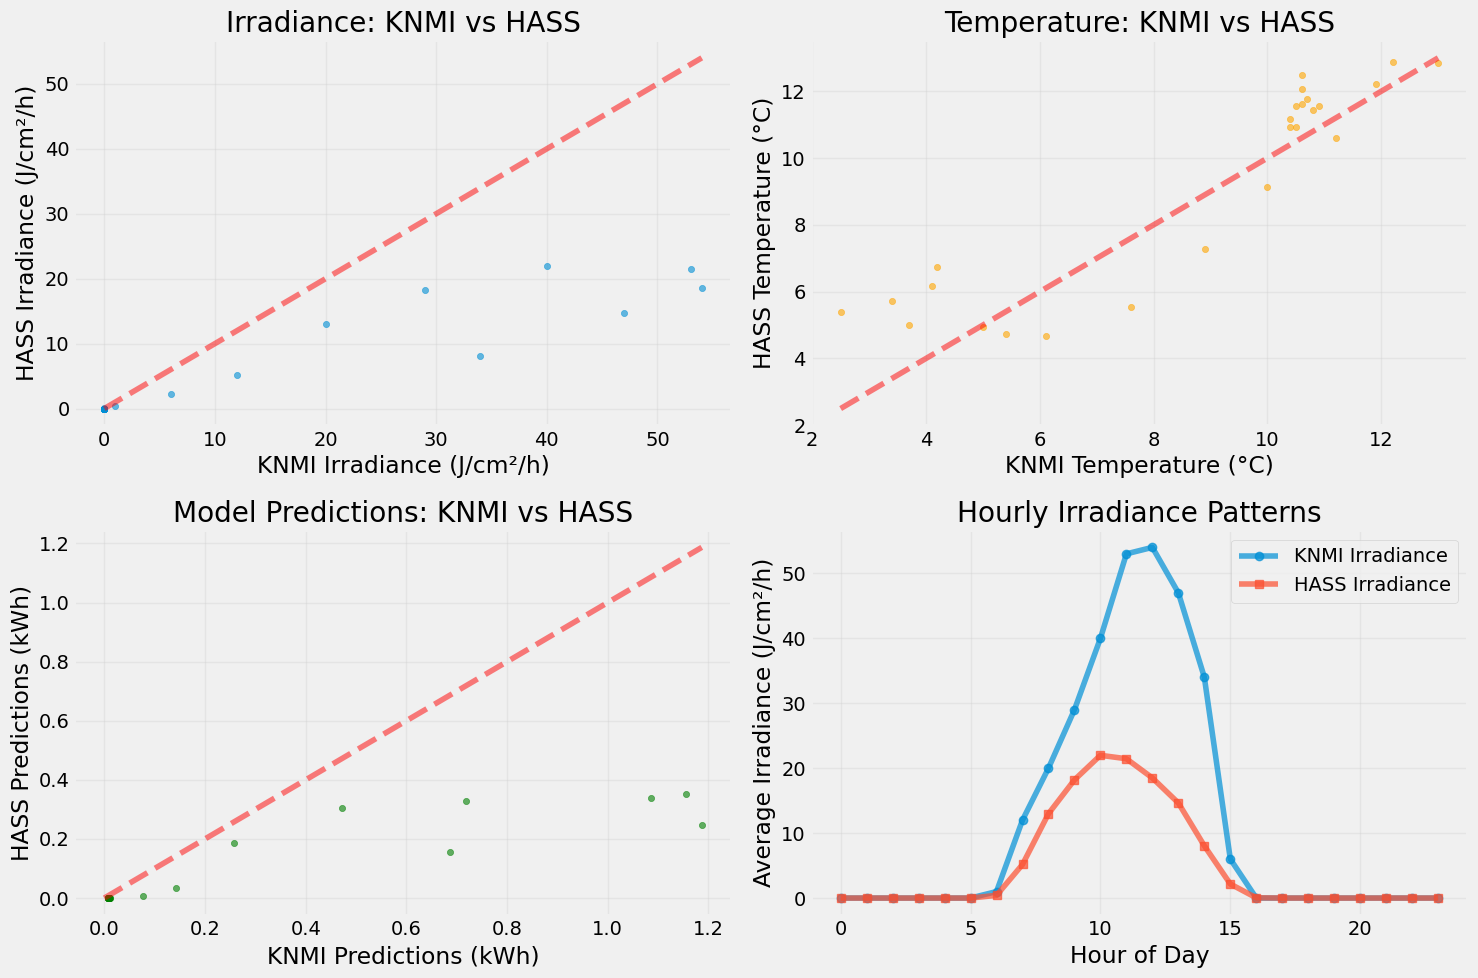

--- Data Source Quality Metrics ---
Missing data points - KNMI: 0, HASS: 0
Irradiance max ratio (HASS/KNMI): 0.407
Temperature range - KNMI: 10.5°C, HASS: 8.2°C

--- Potential Unit Conversion Issues ---
HASS irradiance conversion: W/m² * 3600 / 1000 = J/cm²/h
This conversion factor: 3.6
Check: If HASS sensor reads ~278 W/m² when KNMI shows ~1000 J/cm²/h
Expected: 278 * 3.6 ≈ 1000 ✓

--- Raw Data Sample Comparison ---
Time                 | KNMI Irr | HASS Irr | KNMI Temp | HASS Temp
-----------------------------------------------------------------
2025-11-08 00:00 |      0.0 |      0.0 |       4.2 |       6.8
2025-11-08 01:00 |      0.0 |      0.0 |       4.1 |       6.2
2025-11-08 02:00 |      0.0 |      0.0 |       3.4 |       5.7
2025-11-08 03:00 |      0.0 |      0.0 |       2.5 |       5.4
2025-11-08 04:00 |      0.0 |      0.0 |       3.7 |       5.0


In [226]:
# Visualize data differences and potential causes
print("=== DATA VISUALIZATION ANALYSIS ===")
print()

# Create side-by-side comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Irradiance comparison during prediction period
axes[0,0].scatter(knmi_w['irradiance'], hass_w['irradiance'], alpha=0.6, s=20)
axes[0,0].plot([0, max(knmi_w['irradiance'].max(), hass_w['irradiance'].max())], 
               [0, max(knmi_w['irradiance'].max(), hass_w['irradiance'].max())], 'r--', alpha=0.5)
axes[0,0].set_xlabel('KNMI Irradiance (J/cm²/h)')
axes[0,0].set_ylabel('HASS Irradiance (J/cm²/h)')
axes[0,0].set_title('Irradiance: KNMI vs HASS')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Temperature comparison
axes[0,1].scatter(knmi_w['temperature'], hass_w['temperature'], alpha=0.6, s=20, color='orange')
axes[0,1].plot([knmi_w['temperature'].min(), knmi_w['temperature'].max()], 
               [knmi_w['temperature'].min(), knmi_w['temperature'].max()], 'r--', alpha=0.5)
axes[0,1].set_xlabel('KNMI Temperature (°C)')
axes[0,1].set_ylabel('HASS Temperature (°C)')
axes[0,1].set_title('Temperature: KNMI vs HASS')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Prediction comparison
axes[1,0].scatter(knmi_predictions, hass_predictions, alpha=0.6, s=20, color='green')
axes[1,0].plot([0, knmi_predictions.max()], [0, knmi_predictions.max()], 'r--', alpha=0.5)
axes[1,0].set_xlabel('KNMI Predictions (kWh)')
axes[1,0].set_ylabel('HASS Predictions (kWh)')
axes[1,0].set_title('Model Predictions: KNMI vs HASS')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Hourly pattern comparison
hourly_knmi = knmi_w.groupby(knmi_w.index.hour).mean()
hourly_hass = hass_w.groupby(hass_w.index.hour).mean()

axes[1,1].plot(hourly_knmi.index, hourly_knmi['irradiance'], 'o-', label='KNMI Irradiance', alpha=0.7)
axes[1,1].plot(hourly_hass.index, hourly_hass['irradiance'], 's-', label='HASS Irradiance', alpha=0.7)
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Average Irradiance (J/cm²/h)')
axes[1,1].set_title('Hourly Irradiance Patterns')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantify the data source differences
print("--- Data Source Quality Metrics ---")

# Check for missing data or systematic differences
knmi_missing = knmi_w.isnull().sum().sum()
hass_missing = hass_w.isnull().sum().sum()
print(f"Missing data points - KNMI: {knmi_missing}, HASS: {hass_missing}")

# Check data range ratios
irr_ratio = hass_w['irradiance'].max() / knmi_w['irradiance'].max()
temp_range_knmi = knmi_w['temperature'].max() - knmi_w['temperature'].min()
temp_range_hass = hass_w['temperature'].max() - hass_w['temperature'].min()

print(f"Irradiance max ratio (HASS/KNMI): {irr_ratio:.3f}")
print(f"Temperature range - KNMI: {temp_range_knmi:.1f}°C, HASS: {temp_range_hass:.1f}°C")

# Check for potential unit conversion issues
print(f"\n--- Potential Unit Conversion Issues ---")
print(f"HASS irradiance conversion: W/m² * 3600 / 1000 = J/cm²/h")
print(f"This conversion factor: 3.6")
print(f"Check: If HASS sensor reads ~278 W/m² when KNMI shows ~1000 J/cm²/h")
print(f"Expected: 278 * 3.6 ≈ 1000 ✓")

# Show some raw data comparison
print(f"\n--- Raw Data Sample Comparison ---")
print("Time                 | KNMI Irr | HASS Irr | KNMI Temp | HASS Temp")
print("-" * 65)
for i in range(min(5, len(knmi_w))):
    idx = knmi_w.index[i]
    if idx in hass_w.index:
        print(f"{idx.strftime('%Y-%m-%d %H:%M')} | {knmi_w.loc[idx, 'irradiance']:8.1f} | {hass_w.loc[idx, 'irradiance']:8.1f} | {knmi_w.loc[idx, 'temperature']:9.1f} | {hass_w.loc[idx, 'temperature']:9.1f}")